In [ ]:
# COLAB: uncomment below to setup for Git
# !git clone https://github.com/C7082-2022/labs-cv-colab

In [ ]:
# COLAB: uncomment below to change directory
# %cd labs-cv-colab/03-DL-basics

In [1]:
# setup for images
from IPython.display import Image

# Lab 03 Max pooling


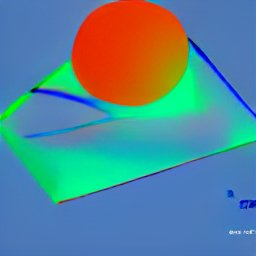

In [6]:
Image("img/craiyon-maxpool.jpg", width = 300)
# Craiyon.com "Max pooling" 


## 1 Objectives 

We have begun our discussion of how the base in a convnet performs feature extraction. We have explored about how the first two operations in this process occur in a `Conv2D` layer with `relu` activation.

In this notebook:
- we'll look at the third (and final) operation in this sequence: **condense** with **maximum pooling**
- do this by implementing a Keras `MaxPool2D` layer



## 2  Condense with Maximum Pooling

Adding condensing step to the model we had before, will give us this:

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # More layers follow
])

A `MaxPool2D` layer is much like a `Conv2D` layer, except that it uses a simple maximum function instead of a kernel, with the `pool_size` parameter analogous to `kernel_size`. A `MaxPool2D` layer doesn't have any trainable weights like a convolutional layer does in its kernel, however.

Let's take another look at the extraction figure from the last lesson. Remember that `MaxPool2D` is the **Condense** step.

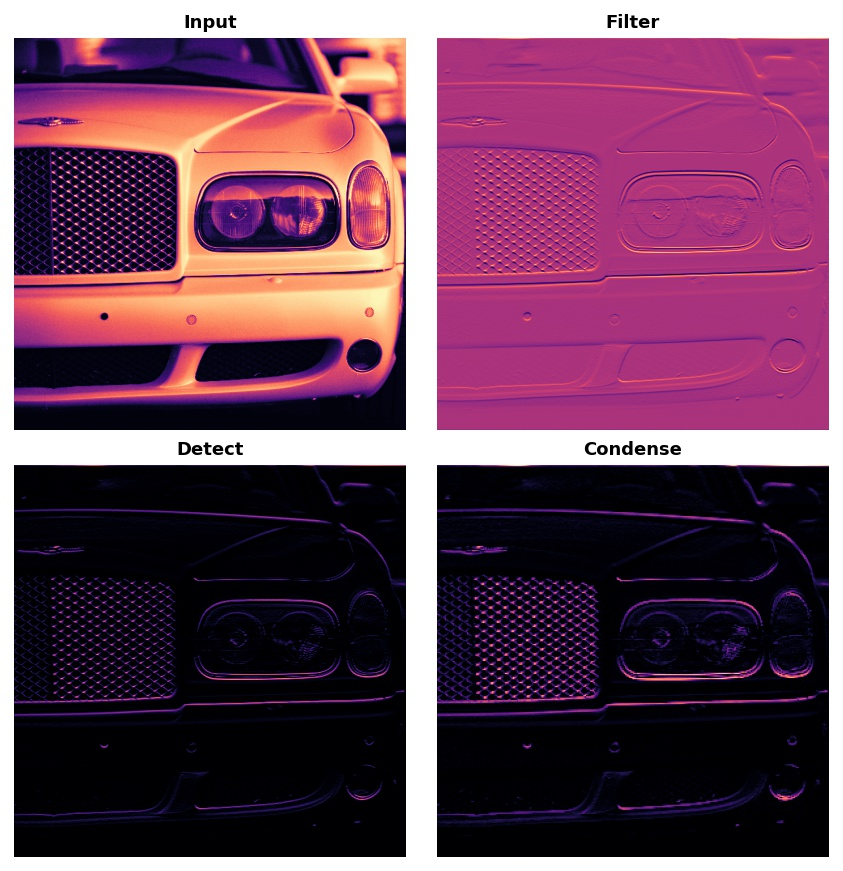

In [9]:
Image("img/2-1.png", width = 600)
# An example of the feature extraction process

Notice that after applying the ReLU function (**Detect**) the feature map ends up with a lot of "dead space," that is, large areas containing only 0's (the black areas in the image). Having to carry these 0 activations through the entire network would increase the size of the model without adding much useful information. Instead, we would like to *condense* the feature map to retain only the most useful part -- the feature itself.

This in fact is what **maximum pooling** does. Max pooling takes a patch of activations in the original feature map and replaces them with the maximum activation in that patch.

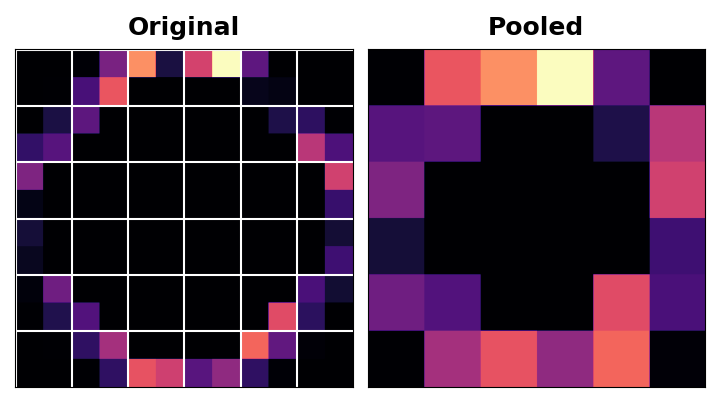

In [10]:
Image("img/3-1.png", width = 600)
# Maximum pooling replaces a patch with the maximum value in that patch

When applied after the ReLU activation, it has the effect of "intensifying" features. The pooling step increases the proportion of active pixels to zero pixels.

## 3 Example - Apply Maximum Pooling

Let's add the "condense" step to the feature extraction we did in the example in Lesson 2. This next hidden cell will take us back to where we left off.

In [ ]:
# Colab
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Read image
image_path = 'img/car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

# Define kernel
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=tf.float32)

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

# Filter step
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two in the next lesson!
    strides=1,
    padding='SAME'
)

# Detect step
image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

<br>

We'll use another one of the functions in `tf.nn` to apply the pooling step, `tf.nn.pool`. This is a Python function that does the same thing as the `MaxPool2D` layer you use when model building, but, being a simple function, is easier to use directly.

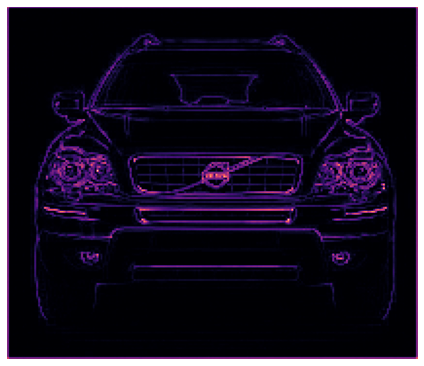

In [3]:
import tensorflow as tf

image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

<br>

Pretty cool! Hopefully you can see how the pooling step was able to intensify the feature by condensing the image around the most active pixels.

## 4 Translation Invariance 

We called the zero-pixels "unimportant". Does this mean they carry no information at all? In fact, the zero-pixels carry *positional information*. The blank space still positions the feature within the image. When `MaxPool2D` removes some of these pixels, it removes some of the positional information in the feature map. This gives a convnet a property called **translation invariance**. This means that a convnet with maximum pooling will tend not to distinguish features by their *location* in the image. ("Translation" is the mathematical word for changing the position of something without rotating it or changing its shape or size.)

Watch what happens when we repeatedly apply maximum pooling to the following feature map.

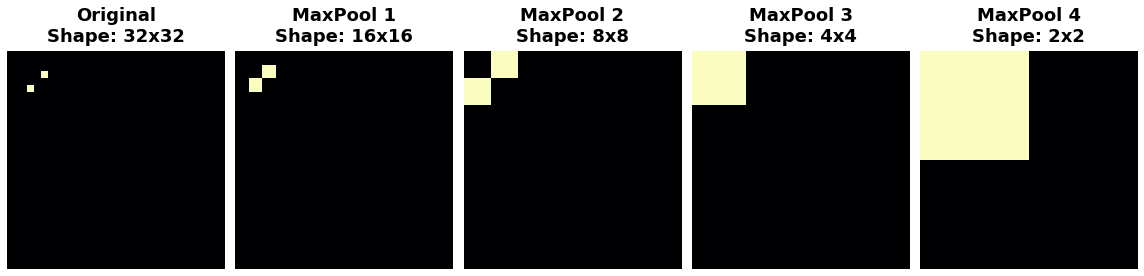

In [11]:
Image("img/3-2.png", width = 600)
# Pooling tends to destroy positional information

<br>

The two dots in the original image became indistinguishable after repeated pooling. In other words, pooling destroyed some of their positional information. Since the network can no longer distinguish between them in the feature maps, it can't distinguish them in the original image either: it has become *invariant* to that difference in position.

In fact, pooling only creates translation invariance in a network *over small distances*, as with the two dots in the image. Features that begin far apart will remain distinct after pooling; only *some* of the positional information was lost, but not all of it.

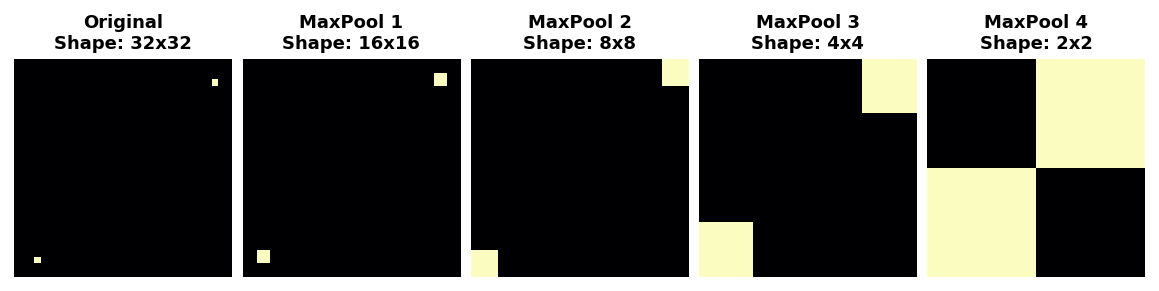

In [13]:
Image("img/3-3.png", width = 600)
# But over large distances two dots far apart stay separated


This invariance to small differences in the positions of features is a nice property for an image classifier to have. Just because of differences in perspective or framing, the same kind of feature might be positioned in various parts of the original image, but we would still like for the classifier to recognize that they are the same. Because this invariance is *built into* the network, we can get away with using much less data for training: we no longer have to teach it to ignore that difference. This gives convolutional networks a big efficiency advantage over a network with only dense layers. 




## 5 Exercises

In these exercises, you'll conclude the feature extraction begun in Exercise 2, explore how invariance is created by maximum pooling, and then look at a different kind of pooling: *average* pooling.

Run the cell below to set everything up.

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

<br>

Run this cell to get back to where you left off in the previous lesson. We'll use a predefined kernel this time.

In [ ]:
# Read image
image_path = 'img/car_illus.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

# Embossing kernel
kernel = tf.constant([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2],
])

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)

image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

### 5.1 Apply Pooling to Condense 

For for the last step in the sequence, apply maximum pooling using a $2 \times 2$ pooling window. You can copy this code to get started:

```
image_condense = tf.nn.pool(
    input=image_detect,
    window_shape=____,
    pooling_type=____,
    strides=(2, 2),
    padding='SAME',
)
```

In [ ]:
# YOUR CODE HERE
image_condense = ____



<br>

Run the next cell to see what maximum pooling did to the feature!

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title("Detect (ReLU)")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title("Condense (MaxPool)")
plt.show();

<br>

We learned about how `MaxPool2D` layers give a convolutional network the property of **translation invariance** over small distances. In this exercise, you'll have a chance to observe this in action.

This next code cell will randomly apply a small shift to a circle and then condense the image several times with maximum pooling. Run the cell once and make note of the image that results at the end.

In [ ]:
REPEATS = 4
SIZE = [64, 64]

# Create a randomly shifted circle
image = visiontools.circle(SIZE, r_shrink=4, val=1)
image = tf.expand_dims(image, axis=-1)
image = visiontools.random_transform(image, jitter=3, fill_method='replicate')
image = tf.squeeze(image)

plt.figure(figsize=(16, 4))
plt.subplot(1, REPEATS+1, 1)
plt.imshow(image, vmin=0, vmax=1)
plt.title("Original\nShape: {}x{}".format(image.shape[0], image.shape[1]))
plt.axis('off')

# Now condense with maximum pooling several times
for i in range(REPEATS):
    ax = plt.subplot(1, REPEATS+1, i+2)
    image = tf.reshape(image, [1, *image.shape, 1])
    image = tf.nn.pool(image, window_shape=(2,2), strides=(2, 2), padding='SAME', pooling_type='MAX')
    image = tf.squeeze(image)
    plt.imshow(image, vmin=0, vmax=1)
    plt.title("MaxPool {}\nShape: {}x{}".format(i+1, image.shape[0], image.shape[1]))
    plt.axis('off')

### 5.2 Explore Invariance #


Suppose you had made a small shift in a different direction -- what effect would you expect that have on the resulting image? Try running the cell a few more times, if you like, to get a new random shift.

**Global Average Pooling**

We mentioned in the previous exercise that average pooling has largely been superceeded by maximum pooling within the convolutional base. There is, however, a kind of average pooling that is still widely used in the *head* of a convnet. This is **global average pooling**. A `GlobalAvgPool2D` layer is often used as an alternative to some or all of the hidden `Dense` layers in the head of the network, like so:

```
model = keras.Sequential([
    pretrained_base,
    layers.GlobalAvgPool2D(),
    layers.Dense(1, activation='sigmoid'),
])
```

<br>

What is this layer doing? Notice that we no longer have the `Flatten` layer that usually comes after the base to transform the 2D feature data to 1D data needed by the classifier. Now the `GlobalAvgPool2D` layer is serving this function. But, instead of "unstacking" the feature (like `Flatten`), it simply replaces the entire feature map with its average value. Though very destructive, it often works quite well and has the advantage of reducing the number of parameters in the model.

Let's look at what `GlobalAvgPool2D` does on some randomly generated feature maps. This will help us to understand how it can "flatten" the stack of feature maps produced by the base.

Run this next cell a few times until you get a feel for how this new layer works.

In [1]:
feature_maps = [visiontools.random_map([5, 5], scale=0.1, decay_power=4) for _ in range(8)]

gs = gridspec.GridSpec(1, 8, wspace=0.01, hspace=0.01)
plt.figure(figsize=(18, 2))
for i, feature_map in enumerate(feature_maps):
    plt.subplot(gs[i])
    plt.imshow(feature_map, vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle('Feature Maps', size=18, weight='bold', y=1.1)
plt.show()

# reformat for TensorFlow
feature_maps_tf = [tf.reshape(feature_map, [1, *feature_map.shape, 1])
                   for feature_map in feature_maps]

global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
pooled_maps = [global_avg_pool(feature_map) for feature_map in feature_maps_tf]
img = np.array(pooled_maps)[:,:,0].T

plt.imshow(img, vmin=0, vmax=1)
plt.axis('off')
plt.title('Pooled Feature Maps')
plt.show();

NameError: name 'visiontools' is not defined

<br>

Since each of the $5 \times 5$ feature maps was reduced to a single value, global pooling reduced the number of parameters needed to represent these features by a factor of 25 -- a substantial savings!

Now we'll move on to understanding the pooled features.

After we've pooled the features into just a single value, does the head still have enough information to determine a class? This part of the exercise will investigate that question.

Let's pass some images from our *Car or Truck* dataset through VGG16 and examine the features that result after pooling. First run this cell to define the model and load the dataset.

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load VGG16
pretrained_base = tf.keras.models.load_model(
    'data/vgg16-pretrained-base',
)

model = keras.Sequential([
    pretrained_base,
    # Attach a global average pooling layer after the base
    layers.GlobalAvgPool2D(),
])

# Load dataset
ds = image_dataset_from_directory(
    'data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=1,
    shuffle=True,
)

ds_iter = iter(ds)

Found 5117 files belonging to 2 classes.


<br>

Notice how we've attached a `GlobalAvgPool2D` layer after the pretrained VGG16 base. Ordinarily, VGG16 will produce 512 feature maps for each image. The `GlobalAvgPool2D` layer reduces each of these to a single value, an "average pixel", if you like.

This next cell will run an image from the *Car or Truck* dataset through VGG16 and show you the 512 average pixels created by `GlobalAvgPool2D`. Run the cell a few times and observe the pixels produced by cars versus the pixels produced by trucks.

In [ ]:
import matplotlib.pyplot as plt
car = next(ds_iter)

car_tf = tf.image.resize(car[0], size=[128, 128])
car_features = model(car_tf)
car_features = tf.reshape(car_features, shape=(16, 32))
label = int(tf.squeeze(car[1]).numpy())

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(["Car", "Truck"][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Pooled Feature Maps')
plt.axis('off')
plt.show();

### 5.3 Understand the Pooled Features 

What do you see? Are the pooled features for cars and trucks different enough to tell them apart? How would you interpret these pooled values? How could this help the classification? After you've thought about it, run the next cell for an answer. (Or see a hint first!)

<br>

Global average pooling is often used in modern convnets. One big advantage is that it greatly reduces the number of parameters in a model, while still telling you if some feature was present in an image or not -- which for classification is usually all that matters. If you're creating a convolutional classifier it's worth trying out!

